One of the problems with using the results from quantum chemical calculations with the RDKit is that typical QM output formats just include atoms and their positions: since the calculations don't need bond orders, they don't show up in the output.
The problem of assigning correct bond orders to the atoms in a molecule based solely on atomic positions (and the overall charge on the molecule) is a non-trivial one, and we've never had a good answer in the RDKit.

A few years ago Jan Jensen and his group published `xyz2mol`, an open-source, RDKit-based solution to this problem written in Python: https://github.com/jensengroup/xyz2mol. During this year's Google Summer of Code, Sreya Gogineni, did a C++ port of the Python code and integrated it into the RDKit core for the 2022.09 release. This post is a quick introduction to how to use that code.

In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True
import rdkit
rdkit.__version__

'2022.09.1'

To get some testing files, I downloaded some structures from the (QM9 dataset)[https://figshare.com/collections/Quantum_chemistry_structures_and_properties_of_134_kilo_molecules/978904]. Here's what those look like: 

In [3]:
!cat ../data/dsgdb9nsd_107313.xyz

19
gdb 107313	2.67642	1.59305	1.14971	3.3443	81.12	-0.2359	-0.0506	0.1853	1106.1507	0.159794	-385.918216	-385.909962	-385.909018	-385.950934	31.892	
C	 0.0645055554	 1.4843171326	 0.3723315122	-0.379845
C	-0.001915467	 0.0516984051	-0.1729357038	-0.277772
C	-1.4001624807	-0.5304376801	-0.1487075838	 0.233551
C	-1.9909553844	-1.0379429662	 1.1601625215	-0.307513
C	-1.7182271444	-1.9962888369	 0.0152208454	-0.158294
C	-2.905416575	-2.2627721735	-0.8489696604	-0.065615
C	-3.3347497536	-1.1525477782	-1.4661914556	-0.191532
C	-2.4353480328	-0.0114763902	-1.1388331005	 0.336742
O	-2.4853518918	 1.1093228549	-1.595794586	-0.340877
H	 1.0876615149	 1.8699729825	 0.3263064541	 0.106173
H	-0.5836533924	 2.142053447	-0.2101812431	 0.152698
H	-0.2626541721	 1.5210712578	 1.4170099662	 0.108877
H	 0.3710335675	 0.0343653078	-1.2041622283	 0.107526
H	 0.662791197	-0.6008609283	 0.4071642198	 0.091428
H	-1.3142481944	-1.0584396879	 2.0096409673	 0.122076
H	-3.0252533013	-0.8199288984	 1.4038330438	 0

Sreya also added an XYZ file format parser to the RDKit, but these files include a bunch of additional information that we need to strip out. Here's the code for that:

In [4]:
# the XYZ files from QM9 aren't really XYZ... clean them up:
def cleanup_qm9_xyz(fname):
    ind = open(fname).readlines()
    nAts = int(ind[0])
    smi = ind[-2].split()[-1]
    ind[1] = '\n'
    ind = ind[:nAts+2]
    for i in range(2,nAts+2):
        l = ind[i]
        l = l.split('\t')
        l.pop(-1)
        ind[i] = '\t'.join(l)+'\n'
    ind = ''.join(ind)
    return ind,smi

In [6]:
ind,smi = cleanup_qm9_xyz('../data/dsgdb9nsd_107313.xyz')
print(ind)


19

C	 0.0645055554	 1.4843171326	 0.3723315122
C	-0.001915467	 0.0516984051	-0.1729357038
C	-1.4001624807	-0.5304376801	-0.1487075838
C	-1.9909553844	-1.0379429662	 1.1601625215
C	-1.7182271444	-1.9962888369	 0.0152208454
C	-2.905416575	-2.2627721735	-0.8489696604
C	-3.3347497536	-1.1525477782	-1.4661914556
C	-2.4353480328	-0.0114763902	-1.1388331005
O	-2.4853518918	 1.1093228549	-1.595794586
H	 1.0876615149	 1.8699729825	 0.3263064541
H	-0.5836533924	 2.142053447	-0.2101812431
H	-0.2626541721	 1.5210712578	 1.4170099662
H	 0.3710335675	 0.0343653078	-1.2041622283
H	 0.662791197	-0.6008609283	 0.4071642198
H	-1.3142481944	-1.0584396879	 2.0096409673
H	-3.0252533013	-0.8199288984	 1.4038330438
H	-0.9412329872	-2.7436632889	 0.1278385726
H	-3.37329736	-3.2394582332	-0.9072563749
H	-4.2004762777	-1.0463782959	-2.1061677066



And now we can construct a molecule:

In [18]:
raw_mol = Chem.MolFromXYZBlock(ind)
print(raw_mol.GetNumAtoms(),raw_mol.GetNumBonds())

15 0


Of course that doesn't yet have bonds. Let's fix that.

Start with `rdDetermineBonds.DetermineConnectivity()`, this uses distances between atoms to determine where there should be bonds, but does not attempt to figure out bond orders.

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

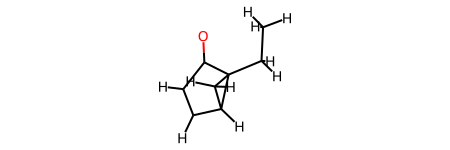

In [10]:
from rdkit.Chem import rdDetermineBonds
conn_mol = Chem.Mol(raw_mol)
rdDetermineBonds.DetermineConnectivity(conn_mol)
conn_mol


Now we can use `rdDetermineBonds.DetermineBondOrders()` to figure out what the bond orders should be.

This requires the overall charge on the molecule (the default value of the charge is zero, so it's not technically necessary to provide it here, but we do so to be clear):

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

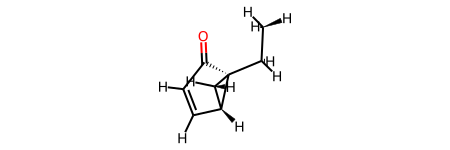

In [11]:
rdDetermineBonds.DetermineBondOrders(conn_mol,charge=0)
conn_mol

We can do both steps in a single call. This is the easiest way to use the code if you just want to look at the final bond orders:

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

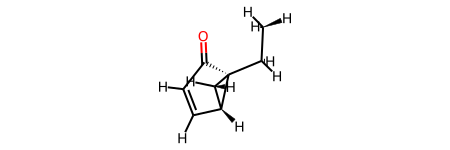

In [12]:
conn_mol = Chem.Mol(raw_mol)
rdDetermineBonds.DetermineBonds(conn_mol,charge=0)
conn_mol


See if the SMILES we got agrees with the what QM9 says it should be:

In [15]:
cm = Chem.RemoveHs(conn_mol)
osmi = Chem.MolToSmiles(cm)
smi = Chem.CanonSmiles(smi)
print(osmi,smi)
osmi==smi

CC[C@]12C[C@H]1C=CC2=O CC[C@]12C[C@H]1C=CC2=O


True

Yep... that's all good.

Let's do another example:

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

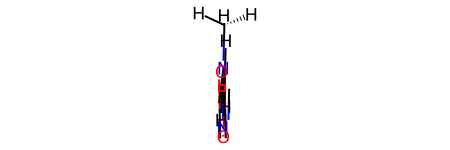

In [16]:
ind,smi = cleanup_qm9_xyz('../data/dsgdb9nsd_127185.xyz')
raw_mol = Chem.MolFromXYZBlock(ind)
conn_mol = Chem.Mol(raw_mol)
rdDetermineBonds.DetermineBonds(conn_mol,charge=0)
conn_mol


In [17]:
cm = Chem.RemoveHs(conn_mol)
osmi = Chem.MolToSmiles(cm)
smi = Chem.CanonSmiles(smi)
print(osmi,smi)
osmi==smi

CN(C=O)c1ccon1 CN(C=O)c1ccon1


True

Since this method needs the Hs to be there, it unfortunately won't be useful in assigning bond orders to the ligands from PDB structures... ah well.